# Environment Setup & Configuration

Purpose: To prepare the environment and load all necessary libraries.

Content:

Cell 1: Mount Google Drive.

Cell 2: Install dependencies (like lime) and import all required modules (pandas, xgboost, shap, etc.).

In [1]:
# Cell 1: Environment Setup & Google Drive Mount
# -----------------------------------------------

from google.colab import drive
drive.mount('/content/drive')

print("\n Google Drive successfully mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Google Drive successfully mounted!


In [2]:
# Cell 2: Install Required Libraries Import All Necessary Libraries
# ----------------------------------
import sys

!pip install xgboost shap joblib
!{sys.executable} -m pip install lime
print("\n Dependency installation complete!")
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import glob
import joblib
import warnings
import time
import gc

# Scikit-learn imports for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Model and XAI imports
import xgboost as xgb
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure settings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("\n All libraries successfully imported!")


 Dependency installation complete!

 All libraries successfully imported!


# Data Ingestion & Preparation
Purpose: To load the raw data and transform it into a clean, usable format for analysis.

Content:

Cell 3: Load all CSV files from Google Drive, execute the full data cleaning pipeline (deduplication, handling nulls), binarize the labels, and split the data into training and testing sets.

In [3]:
# Cell 3: Load and Consolidate Dataset // Data Cleaning and Preprocessing
# ------------------------------------

path_to_csv_folder = '/content/drive/MyDrive/MachineLearningCVE/'

try:
    all_files = glob.glob(path_to_csv_folder + "/*.csv")
    if not all_files:
        print(f" ERROR: No CSV files found in the directory: '{path_to_csv_folder}'. Please verify the path.")
    else:
        df = pd.concat((pd.read_csv(f, on_bad_lines='skip') for f in all_files), ignore_index=True)
        print(f" Dataset successfully loaded! {len(all_files)} files were consolidated.")
        print(f"Initial dataframe shape: {df.shape}")
except Exception as e:
    print(f" An error occurred during data loading: {e}")


if 'df' in locals():
    print("Starting Data Cleaning and Preprocessing...")

    # 1. Strip leading/trailing spaces from column names
    df.columns = df.columns.str.strip()
    print("Step 1/6: Stripped whitespace from column names.")

    # 2. Drop rows with NaN, NULL, or Inf values
    # This is a robust way to handle non-finite values.
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    print("Step 2/6: Removed rows with NaN, NULL, or Inf values.")

    # 3. Drop fully duplicated rows
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    print(f"Step 3/6: Removed {initial_rows - len(df)} duplicate rows.")

    # 4. Binarize the target variable: 'BENIGN' -> 0, All ATTACK labels -> 1
    df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    print("Step 4/6: Binarized the 'Label' column.")

    # 5. Separate features (X) and target (y)
    X = df.drop(columns=['Label'])
    y = df['Label']
    print("Step 5/6: Separated features (X) and target (y).")

    # 6. Split data and scale features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Step 6/6: Split data into training/testing sets and scaled features.")

    print("\n Data preprocessing complete!")
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Testing set shape: {X_test_scaled.shape}")

else:
    print(" DataFrame 'df' not found. Please run the previous cell successfully.")

 Dataset successfully loaded! 8 files were consolidated.
Initial dataframe shape: (2830743, 79)
Starting Data Cleaning and Preprocessing...
Step 1/6: Stripped whitespace from column names.
Step 2/6: Removed rows with NaN, NULL, or Inf values.
Step 3/6: Removed 307078 duplicate rows.
Step 4/6: Binarized the 'Label' column.
Step 5/6: Separated features (X) and target (y).
Step 6/6: Split data into training/testing sets and scaled features.

 Data preprocessing complete!
Training set shape: (1764558, 78)
Testing set shape: (756240, 78)


# Exploratory Data Analysis - EDA


Starting Exploratory Data Analysis (EDA)...


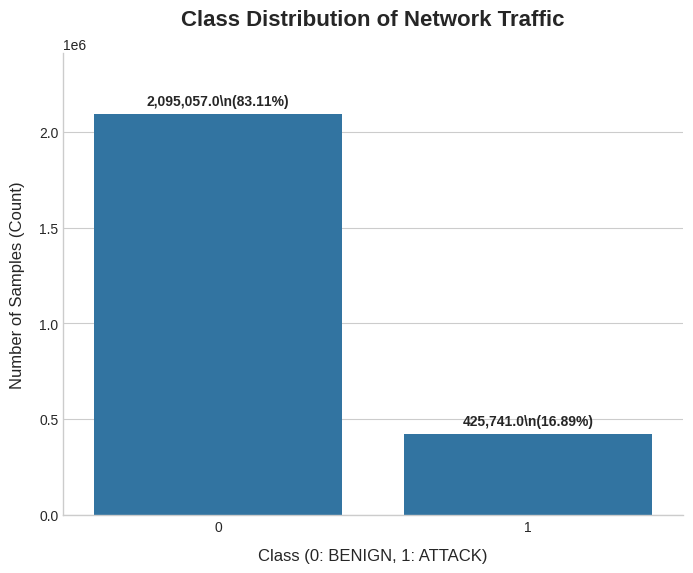

Benign Traffic (0): 2,095,057 (83.11%)
Attack Traffic (1): 425,741 (16.89%)

Analyzing Feature Correlation...
Found 23 features with absolute correlation > 0.95. They are potential candidates for removal.
['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd Packets/s', 'Packet Length Std', 'SYN Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Idle Mean', 'Idle Max', 'Idle Min']


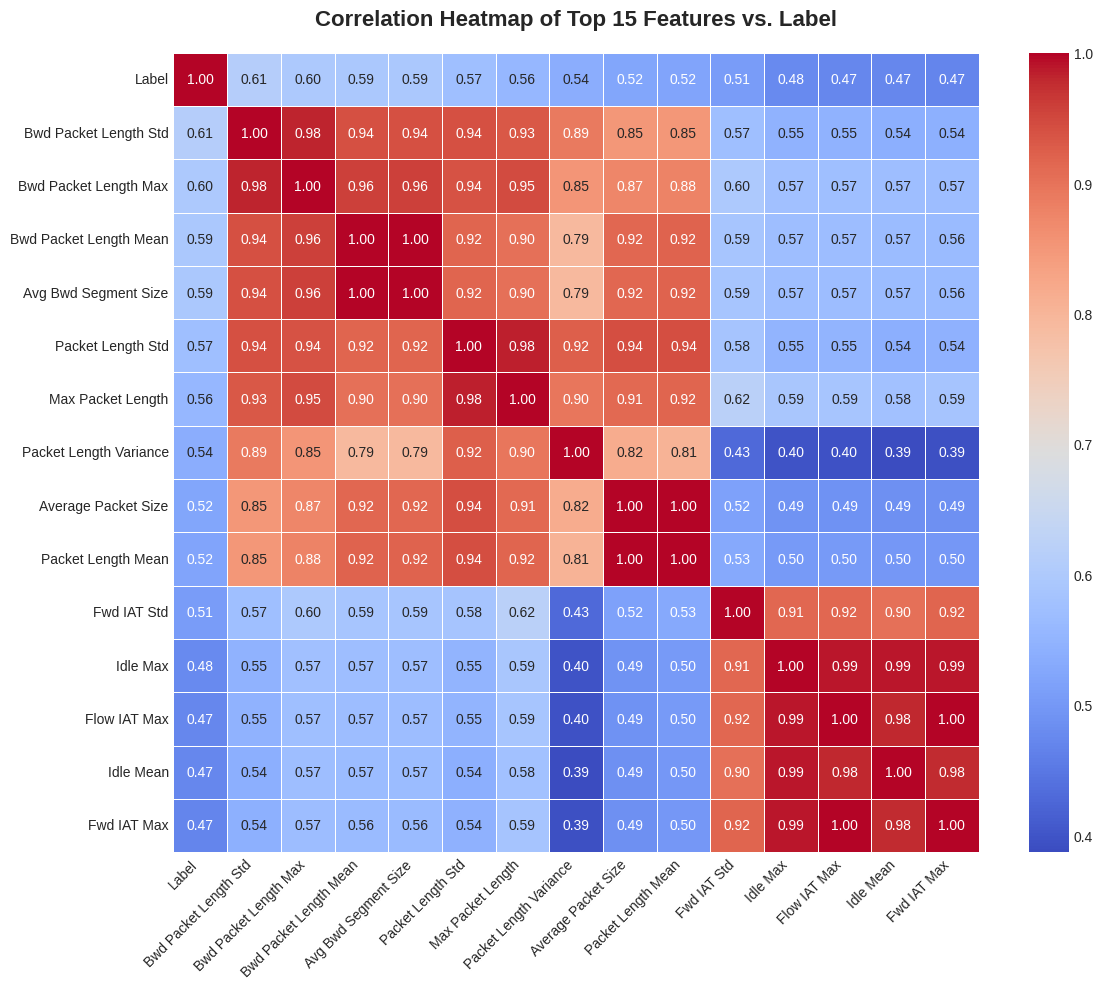


 EDA complete.


In [ ]:
# Cell 4: Exploratory Data Analysis (EDA - A Kaggle Best Practice)
# -----------------------------------------------------------------
# Purpose: To understand the data's characteristics before modeling. This helps in
#          making informed decisions during feature selection and modeling.

if 'df' in locals():
    print("Starting Exploratory Data Analysis (EDA)...")

    # --- Set a professional and consistent plot style for this cell ---
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. Class Distribution Analysis (Improved Aesthetics)
    fig, ax = plt.subplots(figsize=(8, 6)) # Use subplots for more control
    sns.countplot(x='Label', data=df, ax=ax)

    ax.set_title('Class Distribution of Network Traffic', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Class (0: BENIGN, 1: ATTACK)', fontsize=12, labelpad=10)
    ax.set_ylabel('Number of Samples (Count)', fontsize=12, labelpad=10)

    # Calculating and adding annotations for clarity
    total = len(df)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(f'{p.get_height():,}\\n({percentage})', (x, y), ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylim(0, df['Label'].value_counts().max() * 1.15)
    plt.show()

    # Print summary which is also shown on the plot
    label_counts = df['Label'].value_counts()
    print(f"Benign Traffic (0): {label_counts[0]:,} ({ (label_counts[0] / total) * 100:.2f}%)")
    print(f"Attack Traffic (1): {label_counts[1]:,} ({ (label_counts[1] / total) * 100:.2f}%)")


    # 2. Correlation Heatmap of Top Correlated Features (Improved Aesthetics)
    print("\nAnalyzing Feature Correlation...")
    corr_matrix = df.corr() # Using the signed correlation matrix for the heatmap

    # Find features with high absolute correlation for reporting
    upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    print(f"Found {len(to_drop)} features with absolute correlation > 0.95. They are potential candidates for removal.")
    print(to_drop)

    # Visualize the correlation of a subset of features for clarity
    fig, ax = plt.subplots(figsize=(12, 10))

    # We select a smaller number of features to make the heatmap readable
    top_corr_features = corr_matrix.abs().nlargest(15, 'Label').index

    # Use a diverging colormap ('coolwarm') which is better for academic correlation plots
    # Red = positive correlation, Blue = negative correlation, White = zero correlation
    sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features],
                annot=True,
                cmap='coolwarm',
                fmt='.2f',
                linewidths=.5,
                ax=ax)

    ax.set_title('Correlation Heatmap of Top 15 Features vs. Label', fontsize=16, weight='bold', pad=20)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n EDA complete.")

else:
    print(" DataFrame 'df' not found. Please run the previous cells successfully.")

# Feature Selection

 Starting Feature Selection
----------------------------------------------------------------------
[*] Using a sample of 50000 instances for faster feature importance calculation.
[*] Training baseline model to rank features...
[*] Identified the top 30 most important features.
[*] Created new datasets with shape: (1764558, 30)
[*] Visualizing the top features selected...


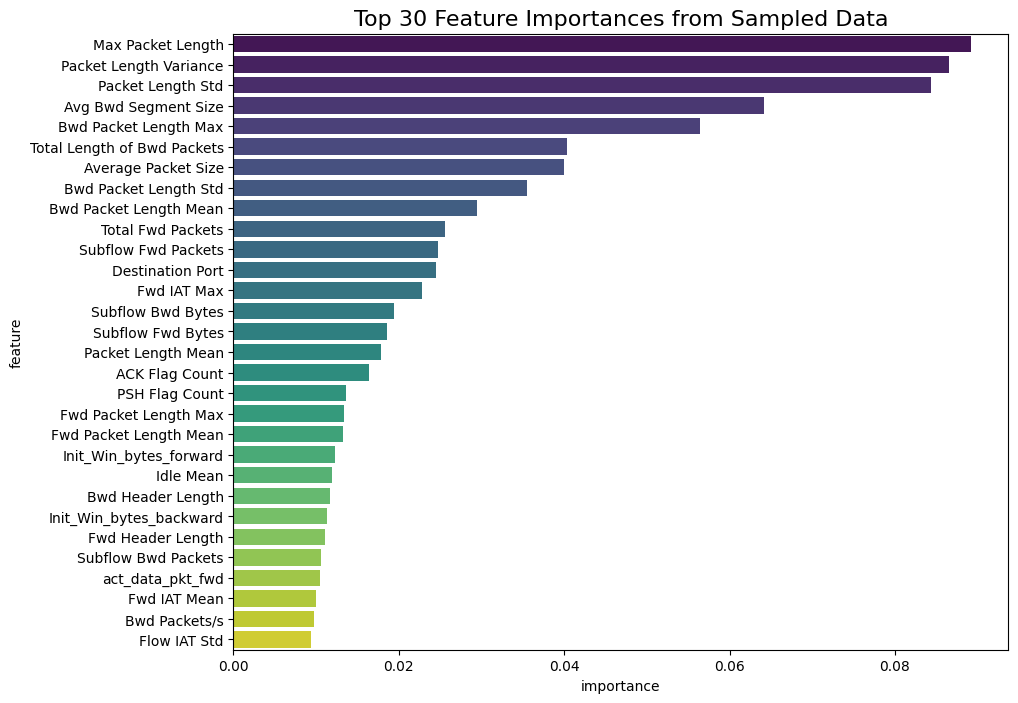


 Feature selection complete. Ready for final model training in the next cell.


In [4]:
# Cell 5: Feature Selection
# ----------------------------------------------------

if 'X_train' in locals():
    print(" Starting Feature Selection")
    print("-" * 70)

    # --- 1. Use a Sample for Faster Importance Calculation ---
    # We take a random sample of the training data to speed up this step significantly.
    # 50,000 samples are more than enough to find the top features reliably.
    SAMPLE_SIZE = 50000
    X_train_sample = X_train.sample(SAMPLE_SIZE, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    print(f"[*] Using a sample of {SAMPLE_SIZE} instances for faster feature importance calculation.")

    # --- 2. Train Baseline Model & Get Importances ---
    # We train a RandomForest model just to rank the features.
    print("[*] Training baseline model to rank features...")
    baseline_rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    baseline_rf.fit(X_train_sample, y_train_sample)

    # --- 3. Select Top Features & Create Final Datasets ---
    # Create a DataFrame of feature importances and select the best ones.
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': baseline_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    N_FEATURES_TO_SELECT = 30
    top_features = feature_importances.head(N_FEATURES_TO_SELECT)['feature'].tolist()
    print(f"[*] Identified the top {N_FEATURES_TO_SELECT} most important features.")

    # Create the final datasets using only these selected features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Scale the new, smaller dataset
    scaler_selected = StandardScaler()
    X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
    X_test_selected_scaled = scaler_selected.transform(X_test_selected)

    print(f"[*] Created new datasets with shape: {X_train_selected_scaled.shape}")

    # --- 4. (Optional) Visualize the Results ---
    # This plot is still highly recommended for your dissertation.
    print("[*] Visualizing the top features selected...")
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(N_FEATURES_TO_SELECT), palette='viridis')
    plt.title(f'Top {N_FEATURES_TO_SELECT} Feature Importances from Sampled Data', fontsize=16)
    plt.show()

    print("\n Feature selection complete. Ready for final model training in the next cell.")

else:
    print(" Training data not found. Please run the data preprocessing cell (Cell 4) successfully.")

# Baseline Model Training & Evaluation

In [ ]:
# Cell 6: Train, Evaluate, and Save Final Models (Combined & Optimized Workflow)
# --------------------------------------------------------------------------------

if 'X_train_selected_scaled' in locals():
    print(" Starting Combined Workflow: Train -> Evaluate -> Save")
    print("="*70)

    # --- 1. RandomForest: Train, Evaluate, Save ---
    # (This part is unchanged as it does not use the GPU in the same way)
    print("\n[Processing RandomForest Model...]")
    # ... (The RandomForest code remains the same) ...
    print("--> Step 1/3: Training Final RandomForest Candidate...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=5)
    rf_model.fit(X_train_selected_scaled, y_train)
    print("    Training complete.")
    print("--> Step 2/3: Evaluating Final RandomForest Performance...")
    y_pred_rf = rf_model.predict(X_test_selected_scaled)
    print("\n--- RandomForest Performance Report ---")
    print(classification_report(y_test, y_pred_rf, target_names=['BENIGN', 'ATTACK']))
    print("--> Step 3/3: Saving Final RandomForest Model...")
    joblib.dump(rf_model, '/content/drive/MyDrive/final_random_forest_model.joblib')
    print("     Final RandomForest model saved to your Google Drive.")

    print("\n" + "="*70)

    # --- 2. XGBoost: Train, Evaluate, Save (with GPU error handling) ---
    print("\n[Processing XGBoost Model...]")
    print("--> Step 1/3: Training Final XGBoost Candidate...")

    try:
        # --- Attempt to use GPU first ---
        print("    Attempting to train XGBoost on the GPU...")
        xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                                      random_state=42, n_estimators=200, max_depth=10, learning_rate=0.1,
                                      tree_method='gpu_hist') # This line requires a GPU
        xgb_model.fit(X_train_selected_scaled, y_train)
        print("     XGBoost model successfully trained on GPU.")

    except xgb.core.XGBoostError:
        # --- Fallback to CPU if GPU fails ---
        print("     WARNING: GPU not available or failed. Automatically switching to CPU for XGBoost training.")
        print("    The training process may be slower.")
        xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                                      random_state=42, n_estimators=200, max_depth=10, learning_rate=0.1,
                                      tree_method='hist') # 'hist' is a fast CPU-based method
        xgb_model.fit(X_train_selected_scaled, y_train)
        print("     XGBoost model successfully trained on CPU.")


    # (b) Evaluate the model immediately after training
    print("--> Step 2/3: Evaluating Final XGBoost Performance...")
    y_pred_xgb = xgb_model.predict(X_test_selected_scaled)
    print("\n--- XGBoost Performance Report ---")
    print(classification_report(y_test, y_pred_xgb, target_names=['BENIGN', 'ATTACK']))

    # (c) Save the validated model
    print("--> Step 3/3: Saving Final XGBoost Model...")
    joblib.dump(xgb_model, '/content/drive/MyDrive/final_xgboost_model.joblib')
    print("     Final XGBoost model saved to your Google Drive.")



    # Assign to final variables for subsequent cells
    final_rf_model = rf_model
    final_xgb_model = xgb_model

else:
    print(" Selected features data not found. Please run the feature selection cell first.")

 Starting Combined Workflow: Train -> Evaluate -> Save

[Processing RandomForest Model...]
--> Step 1/3: Training Final RandomForest Candidate...
    Training complete.
--> Step 2/3: Evaluating Final RandomForest Performance...

--- RandomForest Performance Report ---
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    628518
      ATTACK       1.00      0.99      1.00    127722

    accuracy                           1.00    756240
   macro avg       1.00      1.00      1.00    756240
weighted avg       1.00      1.00      1.00    756240

--> Step 3/3: Saving Final RandomForest Model...
     Final RandomForest model saved to your Google Drive.


[Processing XGBoost Model...]
--> Step 1/3: Training Final XGBoost Candidate...
    Attempting to train XGBoost on the GPU...
     XGBoost model successfully trained on GPU.
--> Step 2/3: Evaluating Final XGBoost Performance...

--- XGBoost Performance Report ---
              precision    reca

# Credibility Audit (I) - Dissecting Model Logic (TRUSTEE Framework)
Purpose: To look inside the model's "black box," understand its decision logic at macro and micro levels, and find evidence of "shortcut learning." This directly corresponds to the TRUSTEE Analysis in your dissertation.

Content:

Cell 7 (Macro-level Analysis): Use SHAP's Beeswarm Plot and Bar Plot to illustrate the model's global feature importances.

Cell 8 (Micro-level Analysis): Use SHAP's Waterfall Plot to provide an in-depth explanation of a prediction for a single, specific attack sample.

 Starting In-Depth XAI Analysis with SHAP (using a sample for efficiency)...
----------------------------------------------------------------------
[*] Plots will be saved to: /content/drive/MyDrive/XAI_Plots/
 SHAP explainer created and values calculated for a sample of 1000 instances.

[Analysis Part 1/2] Global Feature Importance & Effects
----------------------------------------------------------------------

Plot 1: SHAP Beeswarm Summary Plot
  -> Beeswarm plot saved to: /content/drive/MyDrive/XAI_Plots/shap_beeswarm_plot.png


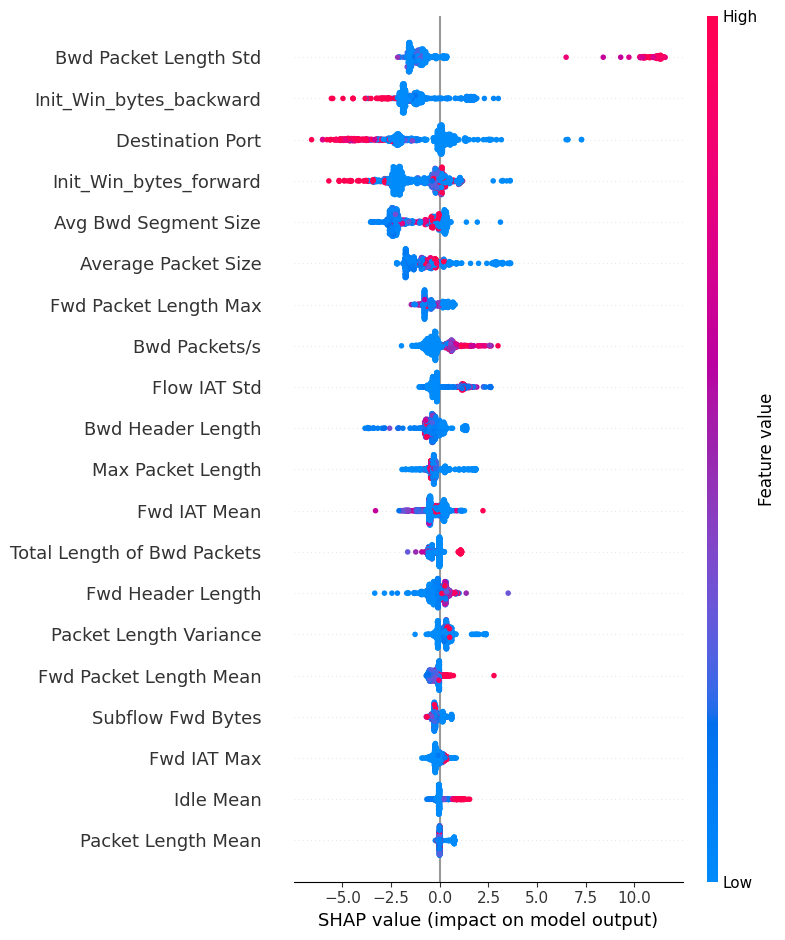


Plot 2: Global Feature Importance (Bar Plot)
  -> Bar plot saved to: /content/drive/MyDrive/XAI_Plots/shap_global_importance_barplot.png


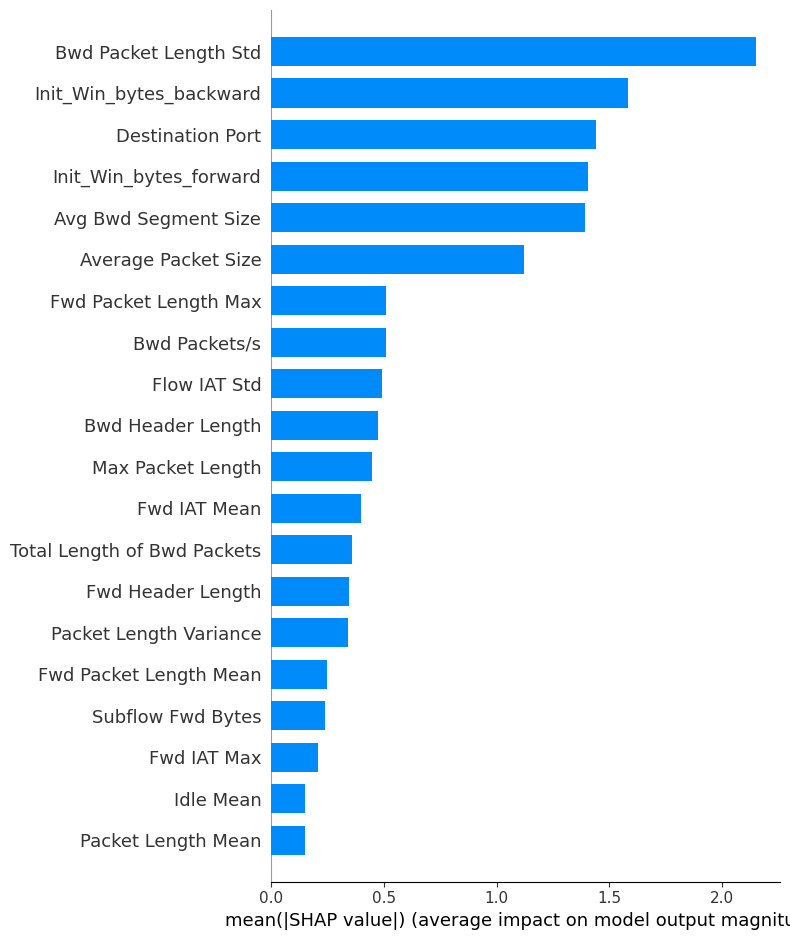


[Analysis Part 2/2] Local Explanation for a Single ATTACK Prediction
----------------------------------------------------------------------
   Analyzing a single, correctly identified ATTACK instance (index: 755435).

Plot 3: SHAP Waterfall Plot for a single prediction
  -> Waterfall plot saved to: /content/drive/MyDrive/XAI_Plots/shap_waterfall_plot_attack_idx_755435.png


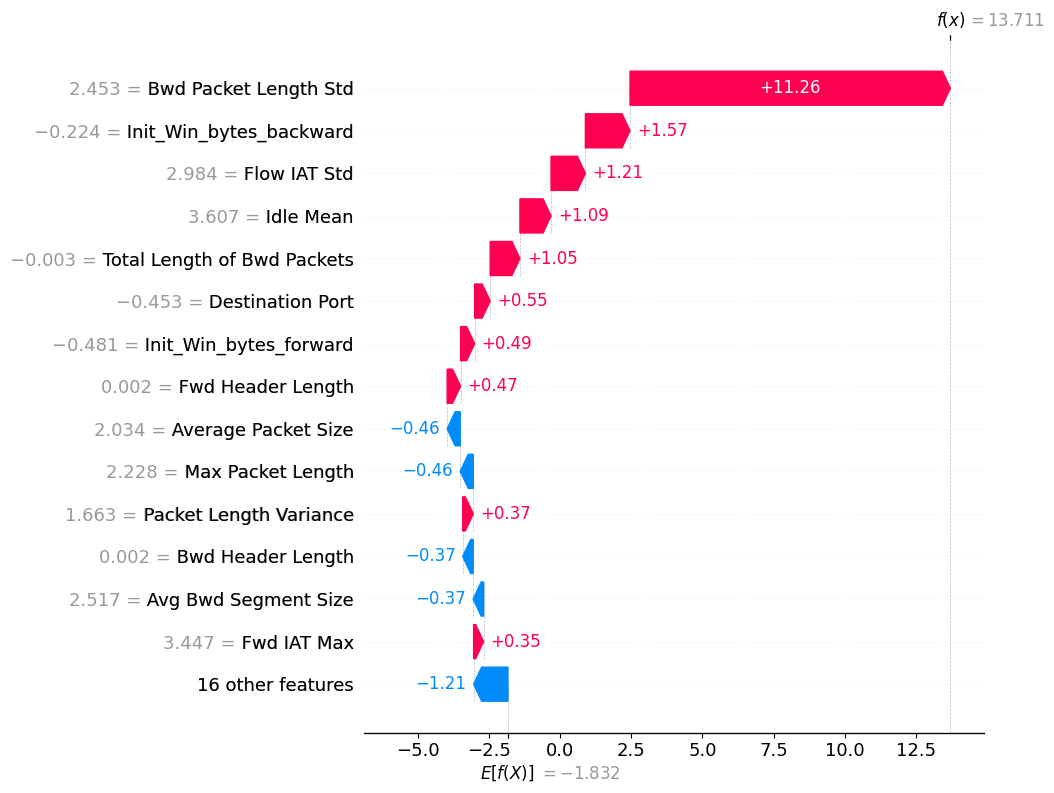


 XAI Analysis complete. All plots saved to disk.


In [7]:
# Cell 7: XAI Analysis with SHAP on a Sample (TRUSTEE Macro & Micro Analysis)
# --------------------------------------------------------------------------------
import os
import matplotlib.pyplot as plt

if 'final_xgb_model' in locals():
    print(" Starting In-Depth XAI Analysis with SHAP (using a sample for efficiency)...")
    print("-" * 70)

    # --- [NEW] Create a directory to save the plots ---
    output_dir = "/content/drive/MyDrive/XAI_Plots/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"[*] Plots will be saved to: {output_dir}")

    # --- 1. Setup the Explainer and Sample the Data ---
    explainer = shap.TreeExplainer(final_xgb_model)

    # --- KEY OPTIMIZATION: Use a random sample, not the full dataset ---
    # We analyze a random sample of 1000 instances from the test set.
    # This is sufficient for global analysis and much faster.
    SAMPLE_SIZE = 1000
    X_test_sample_df = pd.DataFrame(X_test_selected_scaled, columns=top_features).sample(SAMPLE_SIZE, random_state=42)

    # Calculate SHAP values ONLY for the sample.
    shap_explanation_object = explainer(X_test_sample_df)
    print(f" SHAP explainer created and values calculated for a sample of {SAMPLE_SIZE} instances.")

    # --- 2. Global Analysis (TRUSTEE Macro-level) ---
    print("\n[Analysis Part 1/2] Global Feature Importance & Effects")
    print("-" * 70)

    # (a) Beeswarm Plot (Saved as a static image)
    print("\nPlot 1: SHAP Beeswarm Summary Plot")
    shap.summary_plot(shap_explanation_object, X_test_sample_df, plot_type='dot', show=False)
    beeswarm_path = os.path.join(output_dir, 'shap_beeswarm_plot.png')
    plt.savefig(beeswarm_path, bbox_inches='tight')
    print(f"  -> Beeswarm plot saved to: {beeswarm_path}")
    plt.show()
    plt.close()

    # (b) Global Importance Bar Plot (Saved as a static image)
    print("\nPlot 2: Global Feature Importance (Bar Plot)")
    shap.summary_plot(shap_explanation_object, X_test_sample_df, plot_type="bar", show=False)
    barplot_path = os.path.join(output_dir, 'shap_global_importance_barplot.png')
    plt.savefig(barplot_path, bbox_inches='tight')
    print(f"  -> Bar plot saved to: {barplot_path}")
    plt.show()
    plt.close()

    # --- 3. Local Analysis (TRUSTEE Micro-level) ---
    print("\n[Analysis Part 2/2] Local Explanation for a Single ATTACK Prediction")
    print("-" * 70)

    y_pred_sample = final_xgb_model.predict(X_test_sample_df)
    correct_attack_indices = X_test_sample_df[(y_pred_sample == 1)].index

    if not correct_attack_indices.empty:
        instance_index_to_explain = correct_attack_indices[0]
        instance_loc = X_test_sample_df.index.get_loc(instance_index_to_explain)
        print(f"   Analyzing a single, correctly identified ATTACK instance (index: {instance_index_to_explain}).")

        # Use a Waterfall plot for a clearer, more academic visualization
        print("\nPlot 3: SHAP Waterfall Plot for a single prediction")
        shap.plots.waterfall(shap_explanation_object[instance_loc], max_display=15, show=False)

        waterfall_path = os.path.join(output_dir, f'shap_waterfall_plot_attack_idx_{instance_index_to_explain}.png')
        plt.savefig(waterfall_path, bbox_inches='tight')
        print(f"  -> Waterfall plot saved to: {waterfall_path}")
        plt.show()
        plt.close()

    else:
        print("   Could not find a correctly classified attack in the random sample to explain.")

    print("\n XAI Analysis complete. All plots saved to disk.")

else:
    print(" XGBoost model not found. Please run the training cell or load a pre-trained model first.")


[*] Starting LIME vs. SHAP Comparative Analysis (Fully Optimized)...
[*] Plots will be saved to: /content/drive/MyDrive/XAI_Plots/
----------------------------------------------------------------------
[*] Selected Instance 1: A correctly classified ATTACK (index: 22)
[*] Selected Instance 2: A correctly classified BENIGN (index: 0)
----------------------------------------------------------------------

--- Generating LIME Explanation for the ATTACK instance ---
  -> LIME plot saved to: /content/drive/MyDrive/XAI_Plots/lime_explanation_attack_idx_22.png


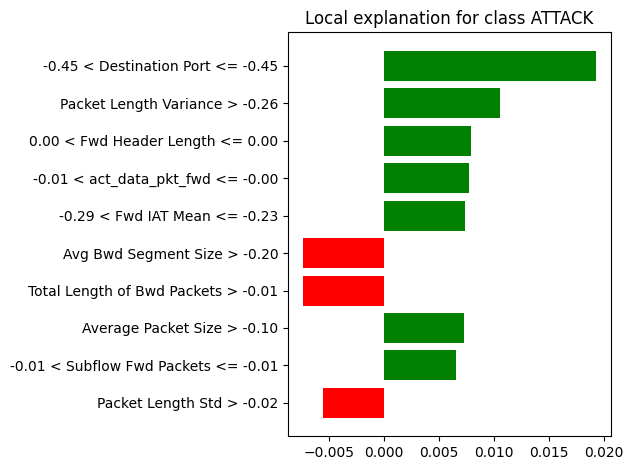



--- Generating SHAP Explanation for the SAME ATTACK instance ---

[SHAP] Waterfall Plot for ATTACK instance (index 22):
  -> SHAP Waterfall plot saved to: /content/drive/MyDrive/XAI_Plots/shap_waterfall_plot_attack_idx_22.png


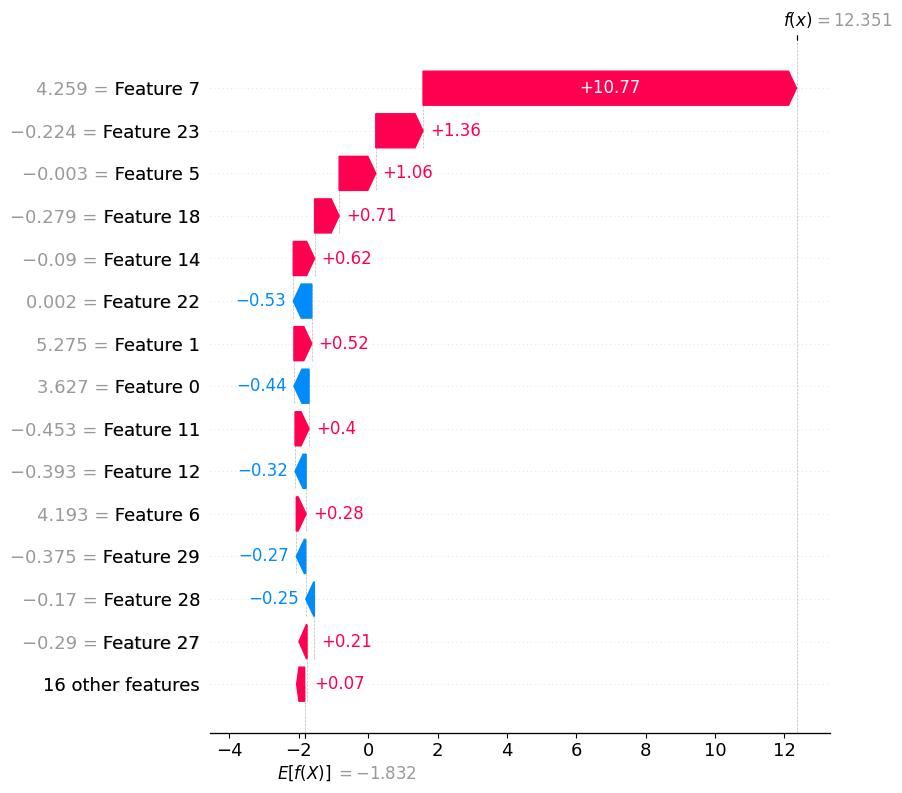


Comparative analysis complete.


In [9]:
# Standalone Experiment: Comparative Analysis - LIME vs. SHAP (Fully Optimized & Corrected)
# ----------------------------------------------------------------------------------

# --- 1. Sanity Check ---
if 'final_xgb_model' in locals() and 'X_test_selected_scaled' in locals():
    print("\n[*] Starting LIME vs. SHAP Comparative Analysis (Fully Optimized)...")

    output_dir = "/content/drive/MyDrive/XAI_Plots/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"[*] Plots will be saved to: {output_dir}")
    print("-" * 70)

    # --- 2. Select Instances for Explanation ---
    y_pred = final_xgb_model.predict(X_test_selected_scaled)
    correct_attack_indices = np.where((y_test == 1) & (y_pred == 1))[0]
    instance_idx_attack = correct_attack_indices[0] if len(correct_attack_indices) > 0 else None
    correct_benign_indices = np.where((y_test == 0) & (y_pred == 0))[0]
    instance_idx_benign = correct_benign_indices[0] if len(correct_benign_indices) > 0 else None

    if instance_idx_attack is not None and instance_idx_benign is not None:
        print(f"[*] Selected Instance 1: A correctly classified ATTACK (index: {instance_idx_attack})")
        print(f"[*] Selected Instance 2: A correctly classified BENIGN (index: {instance_idx_benign})")
        print("-" * 70)

        # --- 3. LIME Explanation (Optimized) ---
        print("\n--- Generating LIME Explanation for the ATTACK instance ---")
        lime_training_sample = shap.utils.sample(X_train_selected_scaled, 10000, random_state=42)
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=lime_training_sample, feature_names=top_features,
            class_names=['BENIGN', 'ATTACK'], mode='classification'
        )
        lime_exp_attack = lime_explainer.explain_instance(
            X_test_selected_scaled[instance_idx_attack],
            final_xgb_model.predict_proba, num_features=10
        )
        lime_fig = lime_exp_attack.as_pyplot_figure()
        lime_fig.tight_layout()
        lime_plot_path = os.path.join(output_dir, f'lime_explanation_attack_idx_{instance_idx_attack}.png')
        lime_fig.savefig(lime_plot_path)
        print(f"  -> LIME plot saved to: {lime_plot_path}")
        plt.show()

        # --- 4. SHAP Explanation (Corrected with Waterfall Plot) ---
        print("\n" + "="*70)
        print("\n--- Generating SHAP Explanation for the SAME ATTACK instance ---")

        shap_explainer = shap.TreeExplainer(final_xgb_model)

        # --- KEY FIX: Select the instance using double brackets to keep it as a 2D array ---
        attack_instance_2d = X_test_selected_scaled[[instance_idx_attack]]
        shap_values_attack = shap_explainer(attack_instance_2d)
        # --- End of Fix ---

        print(f"\n[SHAP] Waterfall Plot for ATTACK instance (index {instance_idx_attack}):")
        # We explain the first (and only) row of our new shap_values_attack object
        shap.plots.waterfall(shap_values_attack[0], max_display=15, show=False)

        waterfall_plot_path = os.path.join(output_dir, f'shap_waterfall_plot_attack_idx_{instance_idx_attack}.png')
        plt.savefig(waterfall_plot_path, bbox_inches='tight')
        print(f"  -> SHAP Waterfall plot saved to: {waterfall_plot_path}")
        plt.show()

        print("\nComparative analysis complete.")
        gc.collect()

    else:
        print("\n[ERROR] Could not find suitable ATTACK or BENIGN instances to analyze.")

else:
    print("\n [FATAL ERROR] Prerequisite data or models not found.")

# Credibility Audit (II) - Credibility Audit II: Fragility & Robustness Testing
Purpose: To actively challenge the model by testing its vulnerability to adversarial tweaks and to build a more robust version.

Content:

Cell 10 (Adversarial Test): Demonstrate the fragility of the original model by modifying the values of a shortcut feature. Remove the shortcut features, retrain a "sanitized" model, and use a comparative SHAP analysis to prove that the new model's logic is more robust.

Cell 11 (Feature Ablation & Retraining): Remove the shortcut features, retrain a "sanitized" model, and use a comparative SHAP analysis to prove that the new model's logic is more robust.




Starting Full Experiment: Ablation, Retraining & SHAP Analysis (Optimized for Load)...
--------------------------------------------------------------------------------
[*] Using a random sample of 200000 instances for this experiment.
[*] The following shortcut features will be removed: ['Average Packet Size', 'Min Packet Length', 'Packet Length Mean']
  -> Sanitized dataset created and scaled.

[*] Retraining a new XGBoost model on the sanitized data...
  -> New 'Sanitized Model' has been trained.

[*] Comparing model performance before and after feature ablation...
  -> F1-Score of Original Model (on ATTACK class): 0.9959
  -> F1-Score of Sanitized Model (on ATTACK class): 0.9951


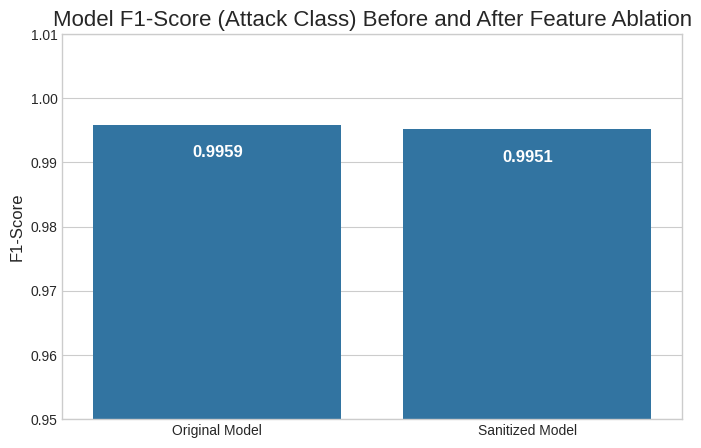


Starting comparative SHAP analysis to compare model logic...



[Step 1/2] Analyzing the Original Model (with shortcuts)...
--- SHAP Summary for Original Model ---


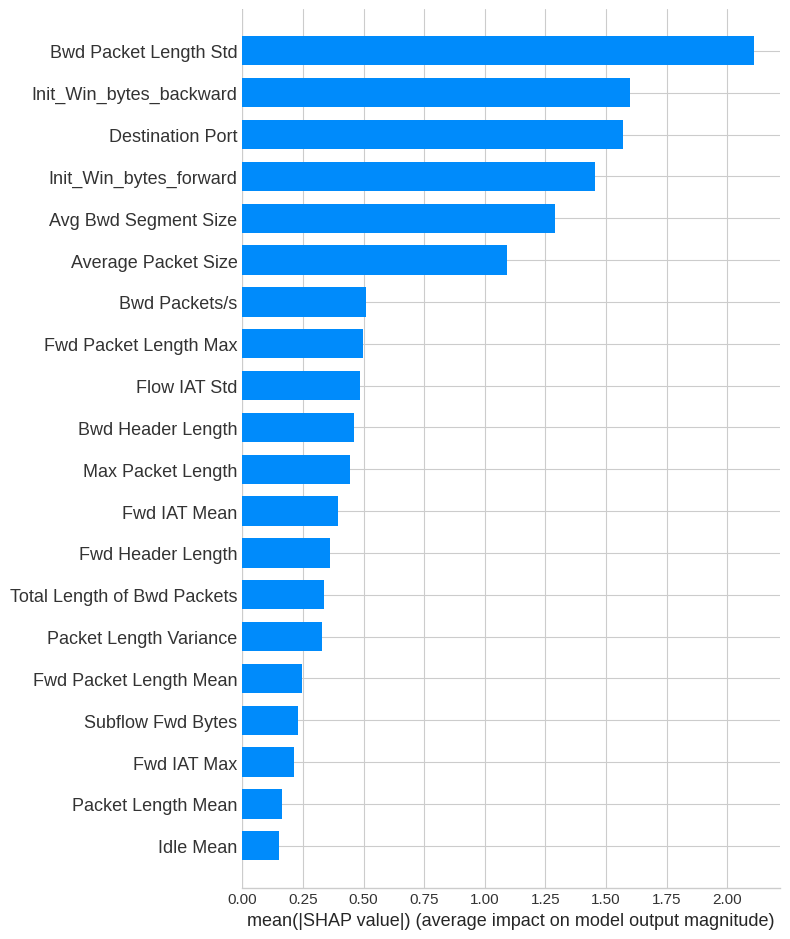


[Step 2/2] Analyzing the Sanitized Model (without shortcuts)...
--- SHAP Summary for Sanitized Model ---


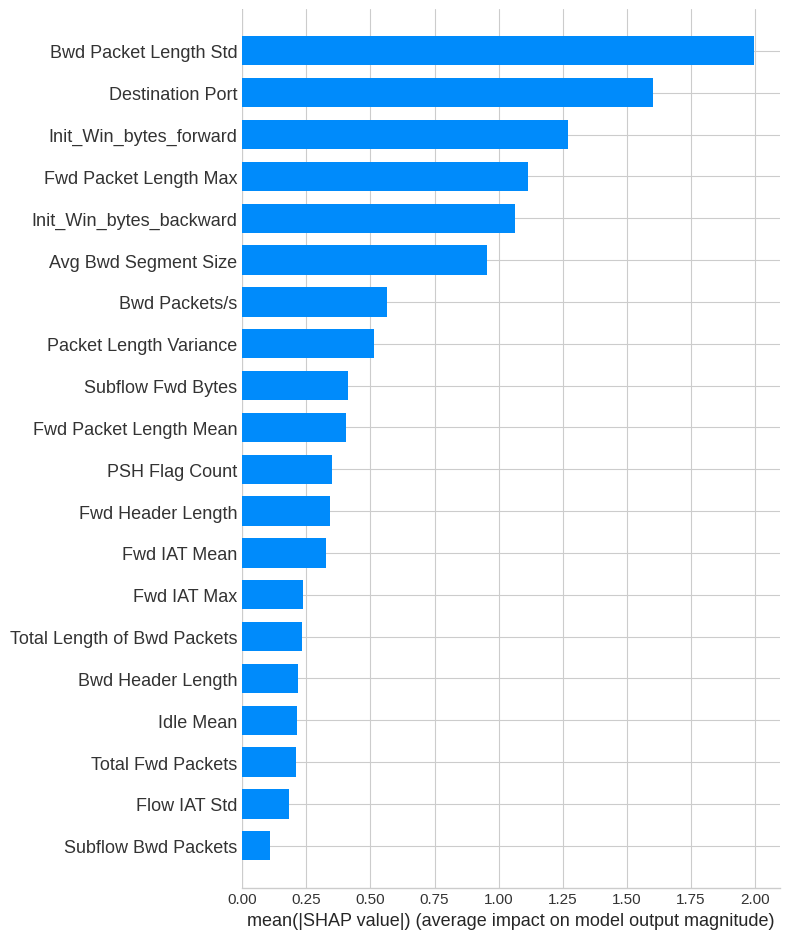


[*] Cleaning up all large variables to free RAM...
  -> Experiment complete and memory cleaned.


In [ ]:
#  cell 10：Feature Ablation, Retraining & Comparative SHAP Analysis
# ------------------------------------------------------------------------------------------



if 'final_xgb_model' in locals() and 'top_features' in locals():
    print("Starting Full Experiment: Ablation, Retraining & SHAP Analysis (Optimized for Load)...")
    print("-" * 80)

    # --- PART 1: DATA SETUP & MODEL RETRAINING ---

    # --- 1a. Subsample the data to reduce memory load ---
    SAMPLE_SIZE = 200000
    if len(X_train) > SAMPLE_SIZE:
        print(f"[*] Using a random sample of {SAMPLE_SIZE} instances for this experiment.")
        X_train_sample = X_train.sample(n=SAMPLE_SIZE, random_state=42)
        y_train_sample = y_train.loc[X_train_sample.index]
    else:
        print("[*] Dataset is smaller than sample size, using full training data.")
        X_train_sample = X_train
        y_train_sample = y_train

    # --- 1b. Create the 'Sanitized' Dataset by removing shortcut features ---
    SHORTCUT_FEATURES_TO_REMOVE = ['Average Packet Size', 'Min Packet Length', 'Packet Length Mean']
    print(f"[*] The following shortcut features will be removed: {SHORTCUT_FEATURES_TO_REMOVE}")

    X_train_sanitized = X_train_sample[top_features].drop(columns=SHORTCUT_FEATURES_TO_REMOVE, errors='ignore')
    X_test_sanitized = X_test[top_features].drop(columns=SHORTCUT_FEATURES_TO_REMOVE, errors='ignore')
    sanitized_features = X_train_sanitized.columns.tolist()

    # Re-scale the sanitized data
    scaler_sanitized = StandardScaler()
    X_train_sanitized_scaled = scaler_sanitized.fit_transform(X_train_sanitized)
    X_test_sanitized_scaled = scaler_sanitized.transform(X_test_sanitized)
    print("  -> Sanitized dataset created and scaled.")

    # --- 1c. Retrain a New Model on Sanitized Data ---
    print("\n[*] Retraining a new XGBoost model on the sanitized data...")
    sanitized_xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        random_state=42, n_estimators=200, max_depth=8, learning_rate=0.1, tree_method='hist'
    )
    sanitized_xgb_model.fit(X_train_sanitized_scaled, y_train_sample)
    print("  -> New 'Sanitized Model' has been trained.")

    # --- 1d. Compare Performance ---
    print("\n[*] Comparing model performance before and after feature ablation...")
    y_pred_original = final_xgb_model.predict(X_test_selected_scaled)
    y_pred_sanitized = sanitized_xgb_model.predict(X_test_sanitized_scaled)

    report_original = classification_report(y_test, y_pred_original, output_dict=True, target_names=['BENIGN', 'ATTACK'])
    report_sanitized = classification_report(y_test, y_pred_sanitized, output_dict=True, target_names=['BENIGN', 'ATTACK'])
    f1_original = report_original['ATTACK']['f1-score']
    f1_sanitized = report_sanitized['ATTACK']['f1-score']

    print(f"  -> F1-Score of Original Model (on ATTACK class): {f1_original:.4f}")
    print(f"  -> F1-Score of Sanitized Model (on ATTACK class): {f1_sanitized:.4f}")

    # Visualize the performance comparison
    plt.figure(figsize=(8, 5))
    sns.barplot(x=['Original Model', 'Sanitized Model'], y=[f1_original, f1_sanitized])
    plt.title('Model F1-Score (Attack Class) Before and After Feature Ablation', fontsize=16)
    plt.ylabel('F1-Score', fontsize=12)
    plt.ylim(0.95, 1.01)
    for index, value in enumerate([f1_original, f1_sanitized]):
        plt.text(index, value - 0.005, f"{value:.4f}", ha='center', fontsize=12, weight='bold', color='white')
    plt.show()

    print("\n" + "="*80)

    # --- PART 2: COMPARATIVE SHAP ANALYSIS ---

    print("Starting comparative SHAP analysis to compare model logic...")
    SHAP_SAMPLE_SIZE = 500
    shap.initjs()

    # --- 2a. Analyze the Original Model's Logic ---
    print("\n[Step 1/2] Analyzing the Original Model (with shortcuts)...")
    explainer_original = shap.TreeExplainer(final_xgb_model)
    X_test_original_sample_df = pd.DataFrame(X_test_selected_scaled, columns=top_features).sample(SHAP_SAMPLE_SIZE, random_state=42)
    shap_values_original = explainer_original(X_test_original_sample_df)

    print("--- SHAP Summary for Original Model ---")
    shap.summary_plot(shap_values_original, X_test_original_sample_df, plot_type="bar", show=True)

    # --- 2b. Analyze the Sanitized Model's Logic ---
    print("\n[Step 2/2] Analyzing the Sanitized Model (without shortcuts)...")
    explainer_sanitized = shap.TreeExplainer(sanitized_xgb_model)
    # We use X_test_sanitized_scaled which was defined earlier in THIS cell
    X_test_sanitized_sample_df = pd.DataFrame(X_test_sanitized_scaled, columns=sanitized_features).sample(SHAP_SAMPLE_SIZE, random_state=42)
    shap_values_sanitized = explainer_sanitized(X_test_sanitized_sample_df)

    print("--- SHAP Summary for Sanitized Model ---")
    shap.summary_plot(shap_values_sanitized, X_test_sanitized_sample_df, plot_type="bar", show=True)

    # --- FINAL CLEANUP ---
    print("\n[*] Cleaning up all large variables to free RAM...")
    del X_train_sample, y_train_sample, X_train_sanitized, X_test_sanitized, X_train_sanitized_scaled, X_test_sanitized_scaled
    del y_pred_original, y_pred_sanitized, explainer_original, explainer_sanitized
    del X_test_original_sample_df, X_test_sanitized_sample_df, shap_values_original, shap_values_sanitized
    gc.collect()
    print("  -> Experiment complete and memory cleaned.")

else:
    print(" Prerequisite data or models not found. Please run all previous cells successfully.")

 Starting Adversarial Test...
Hypothesis: The model's high performance is fragile and relies on shortcut features.
----------------------------------------------------------------------
[*] The target shortcut feature for this test is: 'Average Packet Size'
[*] We will use 10000 true 'ATTACK' samples for this test.

[Step 1/3] Evaluating model performance on ORIGINAL attack samples...
  -> Baseline Accuracy (Correctly identifying attacks): 99.49%

[Step 2/3] Creating adversarial samples by modifying the shortcut feature...
  -> All values of 'Average Packet Size' in attack samples were replaced with: 78.25

[Step 3/3] Evaluating model performance on MODIFIED attack samples...
  -> Adversarial Accuracy (After modification): 85.95%

 Adversarial Test Results:
The model's ability to correctly identify attacks dropped from 99.49% to 85.95%.
This significant drop proves that the model is not truly understanding the attacks,
but is instead relying heavily on a fragile, non-robust shortcut fe

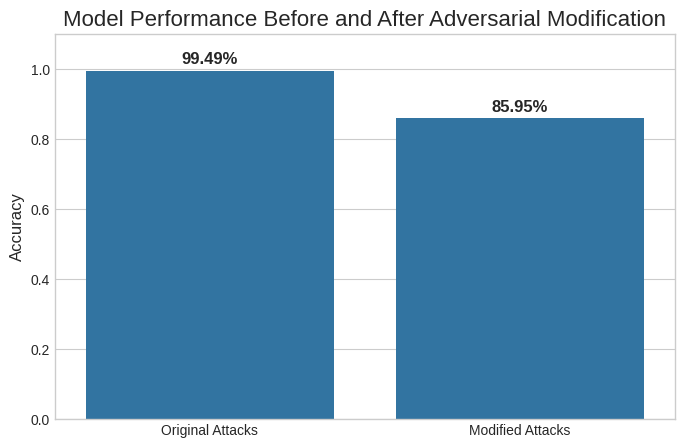

In [ ]:
# Cell 9: Adversarial Test to Prove Model Fragility
# -------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

if 'final_xgb_model' in locals() and 'top_features' in locals():
    print(" Starting Adversarial Test...")
    print("Hypothesis: The model's high performance is fragile and relies on shortcut features.")
    print("-" * 70)

    # --- 1. Experiment Setup ---
    # Define the key parameters for our test
    SHORTCUT_FEATURE = 'Average Packet Size' # The feature we identified as a shortcut
    NUM_SAMPLES = 10000 # Number of attack samples to test

    print(f"[*] The target shortcut feature for this test is: '{SHORTCUT_FEATURE}'")
    print(f"[*] We will use {NUM_SAMPLES} true 'ATTACK' samples for this test.")

    # --- 2. Isolate True Attack Samples ---
    # Create a clean dataframe with both features and the true label
    test_df_with_labels = X_test.copy()
    test_df_with_labels['Label'] = y_test

    # Select only the 'ATTACK' samples that we will manipulate
    attack_samples = test_df_with_labels[test_df_with_labels['Label'] == 1].sample(NUM_SAMPLES, random_state=42)

    # Use only the top features selected in the previous step
    X_adversarial_original = attack_samples[top_features]
    y_adversarial_true = attack_samples['Label']

    # --- 3. Evaluate Baseline Performance ---
    # First, let's see how the model performs on these original, unmodified attack samples.
    print("\n[Step 1/3] Evaluating model performance on ORIGINAL attack samples...")
    X_adversarial_original_scaled = scaler_selected.transform(X_adversarial_original)
    y_pred_baseline = final_xgb_model.predict(X_adversarial_original_scaled)
    baseline_accuracy = accuracy_score(y_adversarial_true, y_pred_baseline)
    print(f"  -> Baseline Accuracy (Correctly identifying attacks): {baseline_accuracy:.2%}")

    # --- 4. Create Adversarial Samples by Modifying the Shortcut Feature ---
    # The core of the attack: we modify the shortcut feature to remove the signal it provides.
    print("\n[Step 2/3] Creating adversarial samples by modifying the shortcut feature...")
    X_adversarial_modified = X_adversarial_original.copy()

    # We replace the shortcut feature's value with a 'normal' value (the median of benign traffic).
    # This removes the signal the model relies on.
    benign_df = df[df['Label'] == 0]
    normal_value = benign_df[SHORTCUT_FEATURE].median()
    X_adversarial_modified[SHORTCUT_FEATURE] = normal_value
    print(f"  -> All values of '{SHORTCUT_FEATURE}' in attack samples were replaced with: {normal_value:.2f}")

    # --- 5. Evaluate Performance on Adversarial Samples ---
    # Now, let's see if the model can still identify these attacks after the modification.
    print("\n[Step 3/3] Evaluating model performance on MODIFIED attack samples...")
    X_adversarial_modified_scaled = scaler_selected.transform(X_adversarial_modified)
    y_pred_adversarial = final_xgb_model.predict(X_adversarial_modified_scaled)
    adversarial_accuracy = accuracy_score(y_adversarial_true, y_pred_adversarial)
    print(f"  -> Adversarial Accuracy (After modification): {adversarial_accuracy:.2%}")

    # --- 6. Visualize and Conclude ---
    print("\n" + "="*70)
    print(" Adversarial Test Results:")
    print("="*70)
    print(f"The model's ability to correctly identify attacks dropped from {baseline_accuracy:.2%} to {adversarial_accuracy:.2%}.")
    print("This significant drop proves that the model is not truly understanding the attacks,")
    print("but is instead relying heavily on a fragile, non-robust shortcut feature.")

    # Visualization to clearly show the drop in performance
    plt.figure(figsize=(8, 5))
    sns.barplot(x=['Original Attacks', 'Modified Attacks'], y=[baseline_accuracy, adversarial_accuracy])
    plt.title('Model Performance Before and After Adversarial Modification', fontsize=16)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.1)
    for index, value in enumerate([baseline_accuracy, adversarial_accuracy]):
        plt.text(index, value + 0.02, f"{value:.2%}", ha='center', fontsize=12, weight='bold')
    plt.show()

else:
    print(" Prerequisite data or models not found. Please run all previous cells successfully.")

# Credibility Audit (III) - Testing the Impact of the Base-Rate Fallacy on Model Precision

Purpose: To evaluate the model's performance under more realistic, non-ideal conditions.

Content:

Cell 12 (Base-Rate Fallacy Test): Test how the model's precision collapses as the prevalence of attack traffic is diluted to more realistic levels.

Cell 13 (Open-World Generalization Test): Test the model's ability to identify attack types it has never seen during training.

[*] Starting Experiment: Impact of Reducing Attack Samples...
Hypothesis: As the number of attack samples decreases, the model's precision will collapse.
----------------------------------------------------------------------
[*] Using a fixed set of 628518 benign samples.

[*] Testing with 10000 attack samples...
  -> Created new test set with 638518 total samples (Attack Prevalence: 1.5661%)

[*] Testing with 1000 attack samples...
  -> Created new test set with 629518 total samples (Attack Prevalence: 0.1589%)

[*] Testing with 100 attack samples...
  -> Created new test set with 628618 total samples (Attack Prevalence: 0.0159%)

[*] Testing with 10 attack samples...
  -> Created new test set with 628528 total samples (Attack Prevalence: 0.0016%)

                Reducing Attack Samples - Test Results
   Num_Attacks Prevalence  Precision True_Positives_Found  False_Positives
0        10000    1.5661%   0.958478           9949/10000              431
1         1000    0.1589%   0.69775

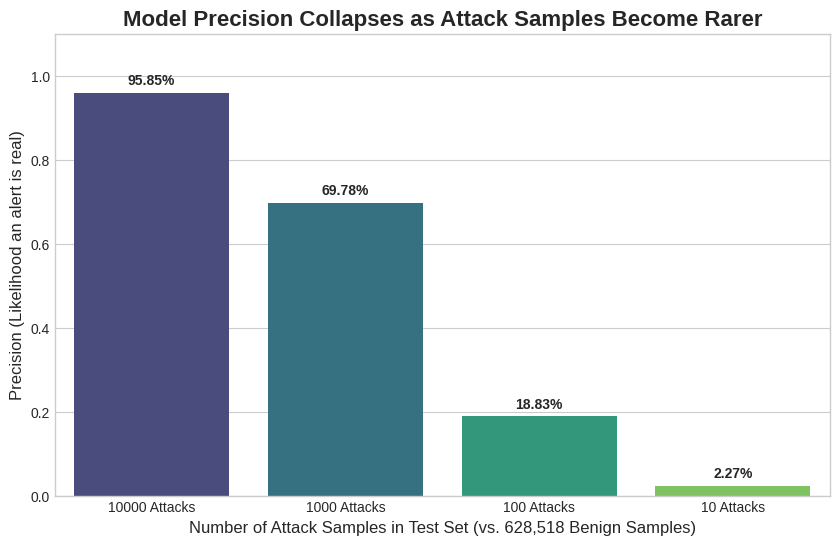

In [ ]:
# Experiment: Impact of Reducing Attack Samples (Alternative Base-Rate Fallacy Test)

# --- 1. Sanity Check: Ensure necessary objects exist ---
if 'final_xgb_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("[*] Starting Experiment: Impact of Reducing Attack Samples...")
    print("Hypothesis: As the number of attack samples decreases, the model's precision will collapse.")
    print("-" * 70)

    # --- 2. Prepare the data subsets ---
    X_test_df = pd.DataFrame(X_test_selected_scaled, columns=top_features)
    y_test_s = pd.Series(y_test.values, index=X_test_df.index)

    # Isolate all attack samples and all benign samples from the original test set
    attack_samples_X = X_test_df[y_test_s == 1]
    benign_samples_X = X_test_df[y_test_s == 0]

    print(f"[*] Using a fixed set of {len(benign_samples_X)} benign samples.")

    # --- 3. Define the number of attack samples to test ---
    num_attacks_to_test = [10000, 1000, 100, 10]
    results = []

    # --- 4. Loop through each scenario and evaluate the model ---
    for num_attacks in num_attacks_to_test:
        if num_attacks > len(attack_samples_X):
            print(f"\n[*] Skipping test for {num_attacks} attacks as it exceeds available samples.")
            continue

        print(f"\n[*] Testing with {num_attacks} attack samples...")

        # Randomly sample the required number of attack instances
        attack_subset_X = attack_samples_X.sample(n=num_attacks, random_state=42)

        # Create the new, realistic test set
        X_test_realistic = pd.concat([attack_subset_X, benign_samples_X])
        y_test_realistic = pd.Series([1]*len(attack_subset_X) + [0]*len(benign_samples_X))

        prevalence = len(attack_subset_X) / len(X_test_realistic)
        print(f"  -> Created new test set with {len(X_test_realistic)} total samples (Attack Prevalence: {prevalence:.4%})")

        # --- Make predictions on this new test set ---
        y_pred_realistic = final_xgb_model.predict(X_test_realistic)

        # --- Calculate and store the key metrics ---
        precision = precision_score(y_test_realistic, y_pred_realistic, zero_division=0)
        cm = confusion_matrix(y_test_realistic, y_pred_realistic)
        true_positives = cm[1, 1]
        false_positives = cm[0, 1]

        results.append({
            'Num_Attacks': num_attacks,
            'Prevalence': f"{prevalence:.4%}",
            'Precision': precision,
            'True_Positives_Found': f"{true_positives}/{num_attacks}",
            'False_Positives': false_positives
        })

    # --- 5. Report and Visualize the Results ---
    results_df = pd.DataFrame(results)

    print("\n" + "="*80)
    print("                Reducing Attack Samples - Test Results")
    print("="*80)
    print(results_df.to_string())

    print("\n\n--- Interpretation ---")
    print("As the number of attack samples decreases, making them rarer, the model's Precision collapses.")
    print("This again demonstrates that in realistic, low-prevalence scenarios, the majority of alerts are false alarms.")

    # Create a bar plot to visualize the drop in precision
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(10, 6))

    results_df['Num_Attacks_Str'] = results_df['Num_Attacks'].astype(str) + ' Attacks'
    sns.barplot(x='Num_Attacks_Str', y='Precision', data=results_df, ax=ax1, palette='viridis')
    ax1.set_title('Model Precision Collapses as Attack Samples Become Rarer', fontsize=16, weight='bold')
    ax1.set_ylabel('Precision (Likelihood an alert is real)', fontsize=12)
    ax1.set_xlabel('Number of Attack Samples in Test Set (vs. 628,518 Benign Samples)', fontsize=12)
    ax1.set_ylim(0, 1.1)

    for p in ax1.patches:
        ax1.annotate(f"{p.get_height():.2%}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points', weight='bold')
    plt.show()

    gc.collect()

else:
    print("\n [FATAL ERROR] Prerequisite data or models not found. Please run your data loading and model training/loading cells first.")

# Stacked Ensemble Model with Decision Tree

Starting training and evaluation of the stacked decision tree model...
--> Loading pre-trained RandomForest and XGBoost models...
    Models loaded successfully.
--> Generating prediction features from base models...
    Prediction feature generation complete.
    Shape of stacked training set: (1764558, 32)
    Shape of stacked testing set: (756240, 32)
--> Training the decision tree meta-model with the stacked dataset...
    Meta-model training complete.
--> Evaluating the performance of the decision tree meta-model...

--- Stacked Decision Tree Model Performance Report ---
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    628518
      ATTACK       1.00      1.00      1.00    127722

    accuracy                           1.00    756240
   macro avg       1.00      1.00      1.00    756240
weighted avg       1.00      1.00      1.00    756240

--> Generating confusion matrix...


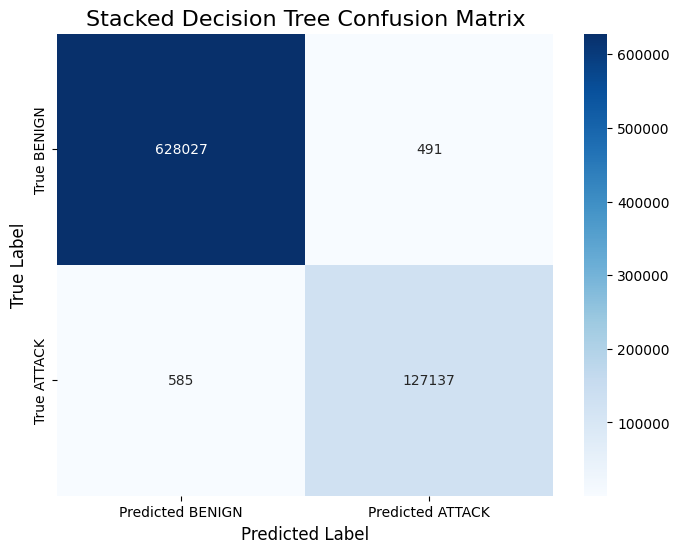

--> Saving the final stacked decision tree meta-model...
    The final stacked decision tree meta-model has been saved to your Google Drive.


In [5]:
# Stacked Decision Tree Model Training and Evaluation

# Objective: Build a simple stacking ensemble model.
#            Use the prediction results from the pre-trained RandomForest and XGBoost models
#            as new features, then train a Decision Tree as a meta-model.

if 'X_train_selected_scaled' in locals():
    print("Starting training and evaluation of the stacked decision tree model...")
    print("=" * 70)

    # --- 1. Import necessary libraries and pre-trained models ---


    # Attempt to load the previously saved base models
    try:
        print("--> Loading pre-trained RandomForest and XGBoost models...")
        # Assumes the previous models were saved with these filenames
        rf_model: ClassifierMixin = joblib.load('/content/drive/MyDrive/final_random_forest_model.joblib')
        xgb_model: xgb.XGBClassifier = joblib.load('/content/drive/MyDrive/final_xgboost_model.joblib')
        print("    Models loaded successfully.")
    except FileNotFoundError:
        print("[ERROR] Pre-trained model files not found. Please ensure the corresponding model training cells have been run and the models were saved successfully.")
        print("    This cell has been skipped.")
        # Clean up memory and exit
        gc.collect()
        # del dt_model, y_pred_dt, cm_dt
        # gc.collect()
        # raise FileNotFoundError("Cannot proceed because the required base model files do not exist.")
    except Exception as e:
        print(f"[ERROR] An error occurred while loading the models: {e}")
        print("    This cell has been skipped.")
        # Clean up memory and exit
        gc.collect()
        # del dt_model, y_pred_dt, cm_dt
        # gc.collect()
        # raise Exception("Cannot proceed because an error occurred while loading the models.")
    else:
        # --- 2. Get predictions from base models for training and testing data ---
        # These predictions will be used as new features
        print("--> Generating prediction features from base models...")
        y_pred_rf_train = rf_model.predict_proba(X_train_selected_scaled)[:, 1] # Get probabilities
        y_pred_xgb_train = xgb_model.predict_proba(X_train_selected_scaled)[:, 1]

        y_pred_rf_test = rf_model.predict_proba(X_test_selected_scaled)[:, 1]
        y_pred_xgb_test = xgb_model.predict_proba(X_test_selected_scaled)[:, 1]
        print("    Prediction feature generation complete.")

        # --- 3. Create the stacked dataset ---
        # Concatenate original features with the new prediction features
        X_train_stacked = np.hstack((X_train_selected_scaled, y_pred_rf_train.reshape(-1, 1), y_pred_xgb_train.reshape(-1, 1)))
        X_test_stacked = np.hstack((X_test_selected_scaled, y_pred_rf_test.reshape(-1, 1), y_pred_xgb_test.reshape(-1, 1)))
        print(f"    Shape of stacked training set: {X_train_stacked.shape}")
        print(f"    Shape of stacked testing set: {X_test_stacked.shape}")

        # --- 4. Train the meta-model (Decision Tree) ---
        print("--> Training the decision tree meta-model with the stacked dataset...")
        # The decision tree acts as the meta-model, using the base models' predictions for the final decision
        dt_meta_model = DecisionTreeClassifier(random_state=42)
        dt_meta_model.fit(X_train_stacked, y_train)
        print("    Meta-model training complete.")

        # --- 5. Evaluate the meta-model performance ---
        print("--> Evaluating the performance of the decision tree meta-model...")
        y_pred_dt_stacked = dt_meta_model.predict(X_test_stacked)

        print("\n--- Stacked Decision Tree Model Performance Report ---")
        print(classification_report(y_test, y_pred_dt_stacked, target_names=['BENIGN', 'ATTACK']))

        # --- 6. Visualize the confusion matrix ---
        print("--> Generating confusion matrix...")
        cm_dt_stacked = confusion_matrix(y_test, y_pred_dt_stacked)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_dt_stacked, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted BENIGN', 'Predicted ATTACK'], yticklabels=['True BENIGN', 'True ATTACK'])
        plt.title('Stacked Decision Tree Confusion Matrix', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.show()

        # --- 7. Save the final meta-model ---
        print("--> Saving the final stacked decision tree meta-model...")
        joblib.dump(dt_meta_model, '/content/drive/MyDrive/final_stacked_decision_tree_model.joblib')
        print("    The final stacked decision tree meta-model has been saved to your Google Drive.")

    # Clean up memory
    del rf_model, xgb_model, dt_meta_model, y_pred_rf_train, y_pred_xgb_train, y_pred_rf_test, y_pred_xgb_test
    del X_train_stacked, X_test_stacked, y_pred_dt_stacked, cm_dt_stacked
    gc.collect()
else:
    print("Feature data not found. Please run the feature selection cell (Cell 5) successfully first.")

